## Mitsuba Disk Experiment 1

In [1]:
import mitsuba              as mi
import matplotlib.pyplot    as plt
mi.variants() # mi.set_variant("llvm_ad_rgb") # mi.set_variant("scalar_rgb") # mi.set_variant("cuda_ad_rgb")
mi.set_variant("llvm_ad_rgb")

In [90]:
bunny = mi.load_dict({
    "type": "obj",
    "filename": "../scenes/meshes/p1-Sphere.obj",
    "face_normals": False,
    "to_world": mi.ScalarTransform4f.scale(0.01),
})

print(bunny)

OBJMesh[
  name = "p1-Sphere.obj",
  bbox = BoundingBox3f[
    min = [-0.499845, 0, -0.5],
    max = [0.499845, 0.499695, 0.5]
  ],
  vertex_count = 12492,
  vertices = [293 KiB of vertex data],
  face_count = 4164,
  faces = [48.8 KiB of face data],
  face_normals = 0
]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.779884].


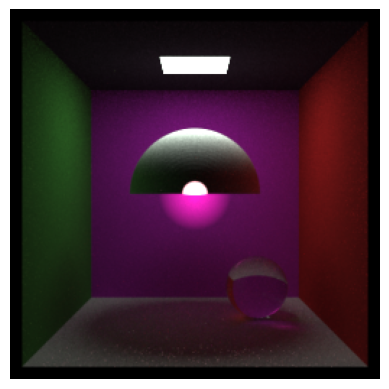

In [2]:
scene   = mi.load_file("../scenes/spherebox.xml")
img1    = mi.render(scene, spp=512)
plt.axis("off")
plt.imshow(img1 ** (1.0 / 1.7))

## Updating the scene

In this example, the color of the emitter is updated.

In [ ]:
scene  = mi.load_file("../scenes/spherebox.xml")
params = mi.traverse(scene)
print(params)
print(params["spot.intensity.value"])

params["spot.intensity.value"] = [5.0 ,5.0 , 15.0]

params.update()
img1    = mi.render(scene, spp=128)
plt.axis("off")
plt.imshow(img1 ** (1.0 / 1.7))

#print(scene.emitters())



# print(em.intensity)
# print(em.to_world)
def dump(obj):
  for attr in dir(obj):
    print("obj.%s = %r" % (attr, getattr(obj, attr)))



In [39]:
import drjit as dr
# Crude mirror model: construction
#
# Let N define the total number of vertices, the first N-1 vertices will compose
# the fringe of the disk, while the last vertex should be placed at the center.
# The first N-1 vertices must have their height modified such that they oscillate
# with some given frequency and amplitude. To compute the face indices, we define
# the first vertex of every face to be the vertex at the center (idx=N-1) and the
# other two can be assigned sequentially (modulo N-2).

N = 50

x_ = dr.linspace(mi.Float, -1.0, -0.5, N)
y_ = dr.linspace(mi.Float, -.8, 0.8, N)

x=[]
y=[]
z=[]

cntN=0
cntM=0

for n in range(N):
    # if cntN >= 100:
    #     n = 199 - n
    #     if n==0:
    #         cntN=0
    #     else:
    #         cntN+=1
    for m in range(N):
        # if cntM >= 100:
        #     n = 199 - n
        #     if n==0:
        #         cntM=0
        #     else:
        #         cntM+=1
        z_ = 0.0
        # print(n,m)
        v = x_[n]**2+y_[m]**2
        if (v)<1.0:
            z_ = dr.sqrt(1-v)
        x.append(x_[n])
        y.append(y_[m])
        z.append(z_)

print(len(z))

# z =   dr.sqrt(2-x**2 - y**2) #   amplitude * dr.sin(theta * frequency)
vertex_pos = mi.Point3f(x, y, z)
# for uu in vertex_pos: print(uu)

N1 = len(z)
M = N1 # *N1


# Generate the face indices
idx = dr.arange(mi.UInt32, M - 1)
face_indices = mi.Vector3u(M - 1, (idx + 1) % (M - 2), idx % (M - 2))

# Create an empty mesh (allocates buffers of the correct size)
mesh = mi.Mesh(
    "wavydisk",
    vertex_count=M,
    face_count=M - 1,
    has_vertex_normals=False,
    has_vertex_texcoords=False,
)

print(idx)
print(face_indices)

2500
[0, 1, 2, 3, 4, .. 2489 skipped .., 2494, 2495, 2496, 2497, 2498]
[[2499, 1, 0],
 [2499, 2, 1],
 [2499, 3, 2],
 [2499, 4, 3],
 [2499, 5, 4],
 .. 2489 skipped ..,
 [2499, 2495, 2494],
 [2499, 2496, 2495],
 [2499, 2497, 2496],
 [2499, 0, 2497],
 [2499, 1, 0]]


In [ ]:

mesh_params = mi.traverse(mesh)
mesh_params["vertex_positions"] = dr.ravel(vertex_pos)
mesh_params["faces"] = dr.ravel(face_indices)
print(mesh_params.update())


scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "path"},
    "light": {"type": "constant"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0, -5, -5], target=[0, 0, 0], up=[0, 0, 1]
        ),
    },
    "wavydisk": mesh,
})

img = mi.render(scene)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(mi.util.convert_to_bitmap(img));
mesh.write_ply("concave.ply")

In [66]:
# Wavy disk construction from the original Mitsuba docs,
# brought here for experimentation with procedural meshes.
#
# Let N define the total number of vertices, the first N-1 vertices will compose
# the fringe of the disk, while the last vertex should be placed at the center.
# The first N-1 vertices must have their height modified such that they oscillate
# with some given frequency and amplitude. To compute the face indices, we define
# the first vertex of every face to be the vertex at the center (idx=N-1) and the
# other two can be assigned sequentially (modulo N-2).

# Disk with a wavy fringe parameters
N = 100
frequency = 12.0
amplitude = 0.4

x = []
y = []
z = []

# Generate the vertex positions
theta = dr.linspace(mi.Float, 0.0, dr.two_pi, N)
xj, yj = dr.sincos(theta)

x.append(xj)
y.append(yj)

zj = amplitude * dr.sin(theta * frequency)
#z = x
vertex_pos = mi.Point3f(xj, yj, zj)



[(Mesh[
  name = "wavydisk",
  bbox = BoundingBox3f[
    min = [-0.999874, -0.999497, -0.399547],
    max = [0.999874, 1, 1.6]
  ],
  vertex_count = 100,
  vertices = [1.17 KiB of vertex data],
  face_count = 99,
  faces = [1.16 KiB of face data],
  face_normals = 0
], {'faces', 'vertex_positions'})]


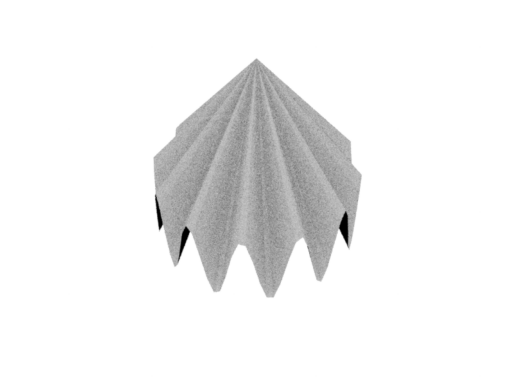

In [67]:


# Move the last vertex to the center
vertex_pos[dr.eq(dr.arange(mi.UInt32, N), N - 1)] = (0., 0., 1.6)

# Generate the face indices
idx = dr.arange(mi.UInt32, N - 1)
face_indices = mi.Vector3u(N - 1, (idx + 1) % (N - 2), idx % (N - 2))


# Create an empty mesh (allocates buffers of the correct size)
mesh = mi.Mesh(
    "wavydisk",
    vertex_count=N,
    face_count=N - 1,
    has_vertex_normals=False,
    has_vertex_texcoords=False,
)

mesh_params = mi.traverse(mesh)
mesh_params["vertex_positions"] = dr.ravel(vertex_pos)
mesh_params["faces"] = dr.ravel(face_indices)
print(mesh_params.update())

scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "path"},
    "light": {"type": "constant"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0, -5, 5], target=[0, 0, 0], up=[0, 0, 1]
        ),
    },
    "wavydisk": mesh,
})

img = mi.render(scene)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(mi.util.convert_to_bitmap(img));
